# Convolutions

We want to understand how GEE convolutions works. We will work with the API function `ee.Kernel.fixed` which creates a convolution kernel operator over an image patch.

We will covolve this kernel with `ee.Image.covolve` function. We want to inspect the convolution values, for this purpose we will use `ee.Image.neighborhoodToBands`. This function returns on bands the values used for the convolution; this is we will have the band `B2_i_j` which corresponds to the band `B2` moved *i* rows and *j* columns.


In [1]:
import ee
ee.Initialize()

im = ee.Image('LANDSAT/LC8_L1T_TOA/LC81980332015119LGN00')

# Mask cloudy pixels
im = ee.Algorithms.Landsat.simpleCloudScore(im)
bands = ['B2','B3','B4','B5']
im = im.updateMask(im.select('cloud').lt(50.0)).select(bands)


In [2]:
kernel_matrix = [[.5,0,.5]]
kernel_convolution = ee.Kernel.fixed(3,1,kernel_matrix,-1,0);
bands_covolved = [bi+"_covolved" for bi in bands]

# Covolve a rename layers
im_convolve = im.convolve(kernel_convolution).select(bands,bands_covolved)
im_neighy = im.neighborhoodToBands(kernel_convolution)

# Create the image with all the layers
im_juntas = im.addBands(im_neighy).addBands(im_convolve)

print("Img with all layers: ",im_juntas.bandNames().getInfo())


('Img with all layers: ', [u'B2', u'B3', u'B4', u'B5', u'B2_-1_0', u'B2_1_0', u'B3_-1_0', u'B3_1_0', u'B4_-1_0', u'B4_1_0', u'B5_-1_0', u'B5_1_0', u'B2_covolved', u'B3_covolved', u'B4_covolved', u'B5_covolved'])


In [3]:
# Download img and inspect
from ee_ipl_uv import download
import os
geom_valencia = ee.Geometry.Polygon([[-0.50262451171875,39.39269330108945],
 [-0.267791748046875,39.38526381099777],
 [-0.26092529296875,39.54005788576377],
 [-0.501251220703125,39.53793974517628],
 [-0.50262451171875,39.39269330108945]])

image_recortada = im_juntas.clip(geom_valencia)
image_name_dir = download.MaybeDownload(image_recortada,image_name_dir="convolution_example")
os.listdir(image_name_dir)

['LC81980332015119LGN00.B3.tfw',
 'LC81980332015119LGN00.B3_covolved.tif',
 'LC81980332015119LGN00.B5_-1_0.tif',
 'LC81980332015119LGN00.B2_-1_0.tfw',
 'LC81980332015119LGN00.B3_1_0.tif',
 'LC81980332015119LGN00.B2_covolved.tfw',
 'LC81980332015119LGN00.B3.tif',
 'LC81980332015119LGN00.B3_-1_0.tfw',
 'LC81980332015119LGN00.B5_1_0.tif',
 'LC81980332015119LGN00.B4.tfw',
 'LC81980332015119LGN00.B2_-1_0.tif',
 'LC81980332015119LGN00.B2.tfw',
 'LC81980332015119LGN00.B4_1_0.tfw',
 'LC81980332015119LGN00.B3_1_0.tfw',
 'LC81980332015119LGN00.B4_covolved.tfw',
 'LC81980332015119LGN00.B2_1_0.tif',
 'LC81980332015119LGN00.B4_1_0.tif',
 'LC81980332015119LGN00.B3_-1_0.tif',
 'LC81980332015119LGN00.B5_-1_0.tfw',
 'LC81980332015119LGN00.B4.tif',
 'LC81980332015119LGN00.B5.tif',
 'LC81980332015119LGN00.B5.tfw',
 'LC81980332015119LGN00.B2_1_0.tfw',
 'LC81980332015119LGN00.B5_covolved.tfw',
 'LC81980332015119LGN00.B2_covolved.tif',
 'LC81980332015119LGN00.B5_1_0.tfw',
 'LC81980332015119LGN00.B4_-1_0.tfw

In [4]:
## Exclude tifs *covolved.tif
tifs_to_read = [ image_name_dir+"/"+fi for fi in sorted(os.listdir(image_name_dir)) if fi.endswith(".tif") and not fi.endswith("covolved.tif") ]
print(tifs_to_read)       
tifs,array = download.ReadImage(tif_files=tifs_to_read)
print(array.shape)


['convolution_example/LC81980332015119LGN00.B2.tif', 'convolution_example/LC81980332015119LGN00.B2_-1_0.tif', 'convolution_example/LC81980332015119LGN00.B2_1_0.tif', 'convolution_example/LC81980332015119LGN00.B3.tif', 'convolution_example/LC81980332015119LGN00.B3_-1_0.tif', 'convolution_example/LC81980332015119LGN00.B3_1_0.tif', 'convolution_example/LC81980332015119LGN00.B4.tif', 'convolution_example/LC81980332015119LGN00.B4_-1_0.tif', 'convolution_example/LC81980332015119LGN00.B4_1_0.tif', 'convolution_example/LC81980332015119LGN00.B5.tif', 'convolution_example/LC81980332015119LGN00.B5_-1_0.tif', 'convolution_example/LC81980332015119LGN00.B5_1_0.tif']
(591, 715, 12)


With the help of `numpy` we can check the lagged values of for example `B2` band.

In [5]:
import numpy as np

bool_array=[ti.find("B2") != -1 for ti in tifs]
layers=[tifs[i] for i in range(0,len(bool_array)) if bool_array[i]]
print(layers)
bool_array = np.asanyarray(bool_array)
print(bool_array)


sliced_array = array[24,24:50,bool_array]

sliced_array = np.transpose(sliced_array)
print(sliced_array.shape)

['convolution_example/LC81980332015119LGN00.B2.tif', 'convolution_example/LC81980332015119LGN00.B2_-1_0.tif', 'convolution_example/LC81980332015119LGN00.B2_1_0.tif']
[ True  True  True False False False False False False False False False]
(26, 3)


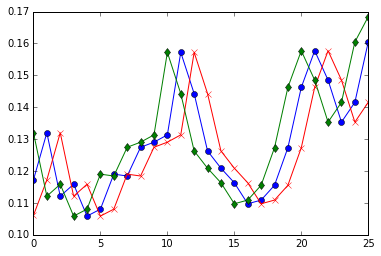

In [6]:
%matplotlib inline
from matplotlib import pyplot as plt

num_elements = sliced_array.shape[0]
plt.plot(np.arange(num_elements),sliced_array[:,0],'bo-')
plt.plot(np.arange(num_elements),sliced_array[:,1],'rx-')
plt.plot(np.arange(num_elements),sliced_array[:,2],'gd-')

['convolution_example/LC81980332015119LGN00.B2_covolved.tif', 'convolution_example/LC81980332015119LGN00.B3_covolved.tif', 'convolution_example/LC81980332015119LGN00.B4_covolved.tif', 'convolution_example/LC81980332015119LGN00.B5_covolved.tif']
(591, 715, 4)


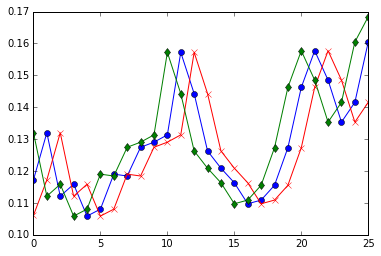

In [9]:
tifs_convolution = [ image_name_dir+"/"+fi for fi in sorted(os.listdir(image_name_dir)) if fi.endswith(".tif") and fi.endswith("covolved.tif") ]

print(tifs_convolution)
_,array_covolved = download.ReadImage(tif_files=tifs_convolution)
print(array_covolved.shape)

sliced_array_covolved = array[24,24:50,0]
num_elements = sliced_array.shape[0]
plt.plot(np.arange(num_elements),sliced_array[:,0],'bo-')
plt.plot(np.arange(num_elements),sliced_array[:,1],'rx-')
plt.plot(np.arange(num_elements),sliced_array[:,2],'gd-')
